<a href="https://colab.research.google.com/github/RDW287/CM3710-Coding-Assessment/blob/main/AI_Image_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Introduction**

The aim of this notebook is to create and compare to two AI algorithms to classify images from the selected dataset. The dataset is images captured using Meta glass, these include rooms and objects within RGU that are categorized/labelled by name.

In [72]:
# Required imports for code
import os
import re
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

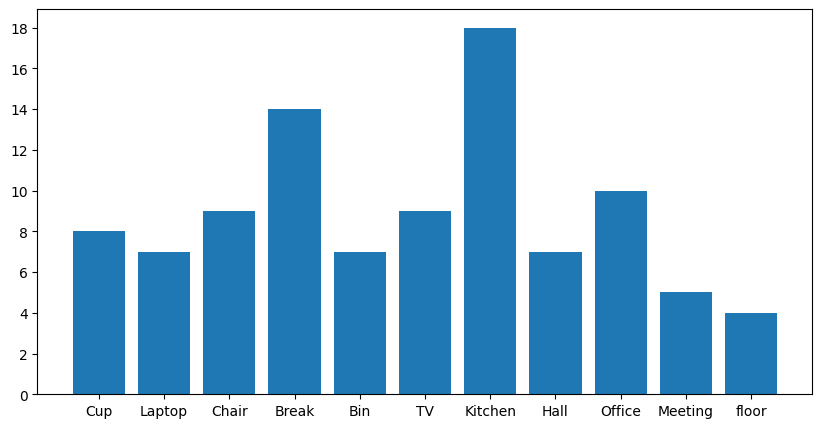

In [71]:
# Data Exploration
dir = "/content/RGU_Images"

image_filenames = []
for file in os.listdir(dir):
  name = re.split('_|-', file) #Splits file names by _ and - to get the label
  image_filenames.append(name[1])

# Gets the count of each label in the dataset
filename_count = Counter(image_filenames)

# The bar graph below shows that not all categories have equal amounts of images, 'floor' only
# has 4 whereas 'kitchen' has 18. In order to help the algorithms learn we should augment these
# images to increase the dataset size.
plt.figure(figsize=(10,5))
plt.bar(filename_count.keys(), filename_count.values())
plt.yticks(range(0,20,2))
plt.show()

In [ ]:
# Data Preprocessing

data_augmentation = keras.Sequential([
      layers.RandomFlip("horizontal_and_vertical"),
      layers.RandomRotation(0.5),
])

#Finish augmentation and show example of image pre and post augmentation.
#Explore image size and